In [1]:
#importing the necessary packages for the preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as bck
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Bidirectional,Dense,LSTM,Dropout
import tensorflow.keras.backend as bck

In [2]:
#loading the data into a variable using the read_csv function from pandas
df=pd.read_csv("agr_en_train.csv",usecols=[1,2],names=['text','label'],header=None)
df.head()

,text,label
0,Well said sonu..you have courage to stand agai...,OAG
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,"Now question is, Pakistan will adhere to this?",OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,"??we r against cow slaughter,so of course it w...",NAG


In [3]:
import nltk
from nltk.corpus import stopwords
#storing the english stopword 
stopword=stopwords.words('english')
print(len(stopword))

179


In [4]:
import re
#using regex to filter out all the non alphabetical characters
regex = re.compile('[^a-zA-Z]')
for i in range(len(df)):
    st=df["text"][i].split()
    tr=""
    for j in st:
        tr=tr+" "+regex.sub('',j)
    df["text"][i]=tr.split()
df.head()

,text,label
0,"[Well, said, sonuyou, have, courage, to, stand...",OAG
1,"[Most, of, Private, Banks, ATMs, Like, HDFC, I...",NAG
2,"[Now, question, is, Pakistan, will, adhere, to...",OAG
3,"[Pakistan, is, comprised, of, fake, muslims, w...",OAG
4,"[we, r, against, cow, slaughterso, of, course,...",NAG


In [5]:
#removing the stopwords from the filtered data
for i in range(len(df)):
    st=[]
    for j in df["text"][i]:
        if j not in stopword:
            st.append(j)
    df["text"][i]=st
df.head()

,text,label
0,"[Well, said, sonuyou, courage, stand, dadagiri...",OAG
1,"[Most, Private, Banks, ATMs, Like, HDFC, ICICI...",NAG
2,"[Now, question, Pakistan, adhere]",OAG
3,"[Pakistan, comprised, fake, muslims, know, mea...",OAG
4,"[r, cow, slaughterso, course, stop, leather, m...",NAG


In [6]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()

In [7]:
#using porterstemmer to stem the words to get all the adjectives removed from the words
for i in range(len(df)):
    for j in range(len(df["text"][i])):
#this helps in reducing the word list by converting words such as study and studying into study and increases the accuracy of the model
        df["text"][i][j]=ps.stem(df["text"][i][j])
df.head()

,text,label
0,"[well, said, sonuy, courag, stand, dadagiri, m...",OAG
1,"[most, privat, bank, atm, like, hdfc, icici, e...",NAG
2,"[now, question, pakistan, adher]",OAG
3,"[pakistan, compris, fake, muslim, know, mean, ...",OAG
4,"[r, cow, slaughterso, cours, stop, leather, ma...",NAG


In [8]:
#creating a map to change the categorical label into numerical label
labelMap={"OAG":2,"CAG":1,"NAG":0}
for i in range(len(df)):
    df["label"][i]=labelMap[df["label"][i]]
df.head()

,text,label
0,"[well, said, sonuy, courag, stand, dadagiri, m...",2
1,"[most, privat, bank, atm, like, hdfc, icici, e...",0
2,"[now, question, pakistan, adher]",2
3,"[pakistan, compris, fake, muslim, know, mean, ...",2
4,"[r, cow, slaughterso, cours, stop, leather, ma...",0


In [9]:
#initializing the alterable values for the model
window=3
worker=3
tokenSize = 20
vectorCount=256

In [10]:
#importing the fasttext model from the gensim library
from gensim.models import FastText
#initializing the fasttext model with vector size of 256
fastTextModel = FastText(size=256)
#training the fasttext model with the text
fastTextModel.build_vocab(df.text)
fastTextModel.train(df.text, window=window, min_count=1, workers=worker, total_examples=fastTextModel.corpus_count,epochs=fastTextModel.epochs)
#storing the trained vector in a variable and deleting the model
x_vectors = fastTextModel.wv
del fastTextModel

In [11]:
#initializing the text length
textLength=len(df.text)
#initializing the training the length
train_length = int(0.9*len(df))
#initializing the test length
test_length = len(df)-train_length
index = set(np.random.choice(textLength, train_length + test_length, replace=False))
#creating the training dataset
X_train = np.zeros((train_length, tokenSize, vectorCount), dtype=bck.floatx())
y_train = np.zeros((train_length, 3), dtype=np.int32)
#creating the testing dataset
x_Test = np.zeros((test_length, tokenSize, vectorCount), dtype=bck.floatx())
y_Test = np.zeros((test_length, 3), dtype=np.int32)

In [12]:
#creating the one hot encoding
encodeMap={"2":[0,0,1],"1":[0,1,0],"0":[1,0,0]}
def trainingEncode(i):
    y_train[i, :]=encodeMap[str(df.label[ind])]

def testingEncode(i):
    y_Test[i-train_length, :]=encodeMap[str(df.label[ind])]

actualLabel=[]
trainingLength = int(0.9*len(df))
testLen = len(df)-trainingLength

In [13]:
#creating the one hot encoding manually
for i, ind in enumerate(index):
    for t, token in enumerate(df.text[ind]):
        if t >= tokenSize:
            break
        if token not in x_vectors:
            continue
        if i < trainingLength:
            X_train[i, t, :] = x_vectors[token]
        else:
            x_Test[i - trainingLength, t, :] = x_vectors[token]
    if i < trainingLength:
        #creating encoding for the training set
        trainingEncode(i)
    else:
        #creating encoding for the testing set
        actualLabel.append(df.label[ind])
        testingEncode(i)

In [14]:
y_train

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [15]:
#initializing the convolutional neural network model 
model = tf.keras.models.Sequential()
#adding a conv1D layer to the model
model.add(tf.keras.layers.Conv1D(768, kernel_size=3, activation='relu',input_shape=(tokenSize, vectorCount)))
#adding a maxpooling layer
model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model.add(tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
model.add(tf.keras.layers.Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.3)))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
#using sparse categorical crossentropy as it is the model which is used to predict multiclass classification 
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 768)           590592    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 768)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 512)            1180160   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 512)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [16]:
#reverting the encoded model into normal neumerical label
def revert(value):
    revertdLevel=[]
    for x in value:
        for i in range(0,len(value[0])):
            if x[i]==1:
                revertdLevel.append(i)
    return revertdLevel
y_train = tf.convert_to_tensor(np.array(revert(y_train)))
y_Test=tf.convert_to_tensor(np.array(revert(y_Test)))

In [17]:
#fitting the neural network  model with the trainable data
hist=model.fit(X_train, y_train, batch_size=100, shuffle=True, epochs=10,validation_split=0.1)
pred=model.predict(x_Test)
prediction=[]


Train on 9719 samples, validate on 1080 samples
Epoch 1/10
9719/9719 [==============================] - 25s 3ms/sample - loss: 1.0744 - accuracy: 0.4301 - val_loss: 1.0822 - val_accuracy: 0.4176
Epoch 2/10
9719/9719 [==============================] - 3s 324us/sample - loss: 1.0646 - accuracy: 0.4290 - val_loss: 1.0716 - val_accuracy: 0.4222
Epoch 3/10
9719/9719 [==============================] - 3s 321us/sample - loss: 1.0632 - accuracy: 0.4266 - val_loss: 1.0635 - val_accuracy: 0.4407
Epoch 4/10
9719/9719 [==============================] - 3s 320us/sample - loss: 1.0596 - accuracy: 0.4323 - val_loss: 1.0632 - val_accuracy: 0.4407
Epoch 5/10
9719/9719 [==============================] - 3s 320us/sample - loss: 1.0593 - accuracy: 0.4363 - val_loss: 1.0987 - val_accuracy: 0.4426
Epoch 6/10
9719/9719 [==============================] - 3s 319us/sample - loss: 1.0571 - accuracy: 0.4335 - val_loss: 1.0708 - val_accuracy: 0.4176
Epoch 7/10
9600/9719 [============================>.] - ETA: 0s -

In [18]:
for i in pred:
    prediction.append(np.argmax(i))

In [19]:
#Evaluation of the model 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
print(confusion_matrix(prediction, actualLabel))
print("The accuracy score is:{}".format(accuracy_score(prediction, actualLabel)))
print("classification report: {}".format(classification_report(prediction, actualLabel)))

[[402 328 174]
 [103  93  66]
 [ 10   8  16]]
The accuracy score is:0.42583333333333334
classification report:               precision    recall  f1-score   support

           0       0.78      0.44      0.57       904
           1       0.22      0.35      0.27       262
           2       0.06      0.47      0.11        34

    accuracy                           0.43      1200
   macro avg       0.35      0.42      0.32      1200
weighted avg       0.64      0.43      0.49      1200



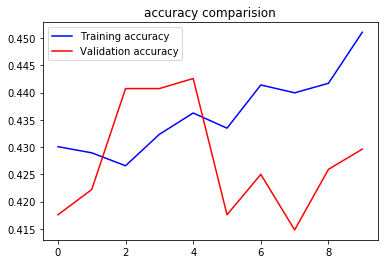

In [20]:
#plotting the validation accuracy graph 
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.title('accuracy comparision')
#plotting the training accuracy
plt.plot( acc, 'b', label='Training accuracy')
#plotting the validation accuracy
plt.plot( val_acc, 'r', label='Validation accuracy')
plt.legend()


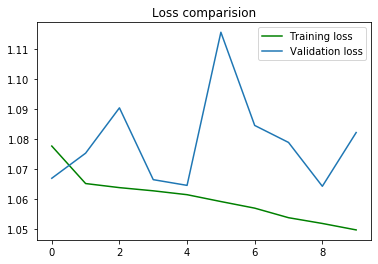

In [21]:
#plotting the validation loss graph 
acc = hist.history['loss']
val_acc = hist.history['val_loss']
plt.title('Loss comparision')
#plotting the training loss
plt.plot( acc, 'g', label='Training loss')
#plotting the validation loss
plt.plot( val_acc, label='Validation loss')
#plotting the legend
plt.legend()